In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict

## Data Collection & Preprocessing

### Hypothesis
Air pollution is directly proportional to both the total number of vehicles and the proportion of high-emission vehicles (above 2000cc) within the total vehicle population.

### Datasets Selection
We sourced multiple high-quality, relevant datasets, which is essential for testing the hypothesis. The two main datasets used are:

- Pollutant Standards Index data from National Environment Agency (NEA), Singapore: This dataset contains daily pollutant data including nitrogen dioxide (NO₂), ozone (O₃), particulate matter (PM10, PM2.5), sulfur dioxide (SO₂), carbon monoxide (CO), and PSI index in different regions in Singapore from 2017 to now. These pollutants were chosen because they are closely linked to vehicular emissions and are commonly monitored in environmental studies.
- Annual Car Population by CC Rating data from Land Transport Authority (LTA), Singapore: This dataset contains the distribution of vehicles by engine capacity (cc rating) from 2005 to 2023. This data is crucial for examining the correlation between vehicle emissions, total vehicle numbers, and air quality, especially in the context of larger vehicles that are expected to contribute more heavily to pollution.

The selection of these datasets is strongly justified given the hypothesis. The vehicle distribution data allows for an analysis of the role played by engine size in pollution, while the pollutant data covers a broad range of relevant air quality indicators over the same period. However, because of the difference in recording time, we chose the common part of the data they have, which is 2017-2023.

### Data Cleaning and Preparation
To ensure the datasets were suitable for analysis, several data cleaning and preprocessing steps were performed:

1. Pollutant Data:
    - daily pollutant data were aggregated at the national level by calculating the average values for each pollutant across all regions of Singapore. This aggregation simplifies the analysis by focusing on national-level trends, which are more relevant to the hypothesis concerning overall vehicle emissions and their impact on air quality.
    - Null values and duplicates were checked within the dataset to ensure data completeness and integrity. Missing data points were identified using the isnull().sum() method, and duplicates were counted using the duplicated().sum() function. By ensuring no major issues with missing or duplicate data, a clean dataset was maintained for further analysis.
    - Outliers were identified using the interquartile range (IQR) method. This method involves calculating the first and third quartiles (Q1 and Q3) and defining outliers as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR. Identifying and handling outliers is an important step to ensure that extreme values do not disproportionately skew the results.
    - Additionally, the pollutant data was filtered to include only those pollutants directly linked to vehicular emissions, such as NO₂, PM10, and CO, among others. This step was crucial in focusing the analysis on the most relevant variables.
2. Vehicle Distribution Data:
    - The vehicle distribution dataset was also cleaned for null values and duplicates. Any missing or erroneous data points were identified and handled, ensuring that the dataset was free of inconsistencies that could impact the analysis.
    - The data was filtered to include only vehicles from 2017 to 2023, ensuring temporal consistency with the pollutant dataset. This filtering was crucial for maintaining alignment between the two datasets.
    - Outliers were identified using the interquartile range (IQR) method. We did find some outliers in this part, but after verification, these outliers are normal data, because the air pollution was serious these days.

### Feature Engineering
To further enhance the datasets and tailor them to the hypothesis, several new features were created:

- Engine Capacity Classification: A new feature was engineered to classify vehicles based on their engine capacity. Specifically, a binary column (above_2000cc) was created to mark whether each vehicle’s engine capacity exceeded 2000cc. This classification is critical to the analysis, as the hypothesis posits that larger vehicles contribute more significantly to air pollution.
- Yearly Aggregation of Pollutants: The pollutant data was aggregated by year, with national averages calculated for each pollutant. This aggregation aligns the data with the vehicle distribution dataset, which is also analyzed every year. By focusing on yearly averages, the analysis aims to capture long-term trends rather than short-term fluctuations in pollutant levels.
- Vehicle Distribution by Year and Engine Capacity: The vehicle distribution data was grouped by year and engine capacity, allowing for an analysis of trends in vehicle population over time. In particular, the number of large vehicles (those with engine capacities above 2000cc) was calculated for each year. This feature enables a direct comparison between the overall number of vehicles and the proportion of high-emission vehicles in the population.
- Merged Data: After cleaning and preprocessing both datasets, they were merged on the year column to allow for a direct comparison between the vehicle distribution data and pollutant levels.

In [29]:
def get_pollutant_data_from_2017_to_2023():
    # URL to get pollutant data.
    base_url = "https://api-open.data.gov.sg/v2/real-time/api/psi"
    
    # Date range for data collection.
    start_date = datetime(2017, 1, 1)
    end_date = datetime(2023, 12, 31)
    
    # Initializes a dictionary to store daily average data.
    daily_avg_pollutant_data = defaultdict(list)
    
    # Requesting data day by day.
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        response = requests.get(base_url, params={'date': date_str})
    
        if response.status_code == 200:
            data = response.json()
    
            # Processing data of every day.
            for item in data['data']['items']:
                timestamp = item['timestamp']
                readings = item['readings']
    
                # Iterate each pollutant and its regional data.
                for pollutant, regions in readings.items():
                    for region, value in regions.items():
                        daily_avg_pollutant_data['date'].append(timestamp[:10])
                        daily_avg_pollutant_data['region'].append(region)
                        daily_avg_pollutant_data['pollutant'].append(pollutant)
                        daily_avg_pollutant_data['value'].append(value)
        else:
            print(f"Failed to retrieve data for {date_str}")
    
        # Next day
        current_date += timedelta(days=1)
    
    # Covert data to data frame.
    df_daily_avg_pollutant_data = pd.DataFrame(daily_avg_pollutant_data)
    
    # Group by date, region, and pollutant, and calculate daily averages.
    df_daily_avg = df_daily_avg_pollutant_data.groupby(['date', 'region', 'pollutant']).mean().reset_index()
    
    save_path = 'Singapore/daily_avg_psi_2017_2023.csv'
    
    # Save as CSV, make data retrieve conveniently.
    df_daily_avg.to_csv(save_path, index=False)

In [30]:
# Execute function to retrieve pollutant data.
# get_pollutant_data_from_2017_to_2023()

In [31]:
# Collect vehicle distribution and daily pollutant data from csv file.
df_vehicle_distribution = pd.read_csv('Singapore/vehicle_distribution_by_CC.csv')
df_daily_avg_pollutant_data = pd.read_csv('Singapore/daily_avg_psi_2017_2023.csv')

In [32]:
# Determine whether there are null values in the df_vehicle_distribution.
df_vehicle_distribution.isnull().sum()

year         0
cc_rating    0
number       0
dtype: int64

In [33]:
# Determine whether there are null values in the df_daily_avg_pollutant_data.
df_daily_avg_pollutant_data.isnull().sum()

date         0
region       0
pollutant    0
value        0
dtype: int64

In [34]:
# Check for duplicates.
print(f"There are {df_vehicle_distribution.duplicated().sum()} duplicates in Vehicle Distribution DataFrame")
print(f"There are {df_daily_avg_pollutant_data.duplicated().sum()} duplicates in Daily Average Pollutant Data DataFrame")

There are 0 duplicates in Vehicle Distribution DataFrame
There are 0 duplicates in Daily Average Pollutant Data DataFrame


In [35]:
# Calculate the first quartile (25th percentile) of the 'number_of_inmates' column
Q1 = df_vehicle_distribution['number'].quantile(0.25)
# Calculate the third quartile (75th percentile) of the 'number_of_inmates' column
Q3 = df_vehicle_distribution['number'].quantile(0.75)
# Calculate the Inter-quartile Range (IQR) which is the difference between Q3 and Q1
IQR = Q3 - Q1
# Calculate the lower bound for outliers, typically 1.5 times below the IQR from Q1
lower_bound = Q1 - 1.5 * IQR
# Calculate the upper bound for outliers, typically 1.5 times above the IQR from Q3
upper_bound = Q3 + 1.5 * IQR
# Identify outliers: rows where 'number_of_inmates' is either below the lower bound or above the upper bound
outliers = df_vehicle_distribution[(df_vehicle_distribution['number'] < lower_bound) | (df_vehicle_distribution['number'] > upper_bound)]
outliers.head()

,year,cc_rating,number


In [36]:
# Create a dictionary to store outliers for each pollutant
outliers_dict = {}

# Iterate over each unique pollutant
for pollutant in df_daily_avg_pollutant_data['pollutant'].unique():
    df_pollutant = df_daily_avg_pollutant_data[df_daily_avg_pollutant_data['pollutant'] == pollutant]
    
    # Calculate IQR
    Q1 = df_pollutant['value'].quantile(0.25)
    Q3 = df_pollutant['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the outliers
    outliers = df_pollutant[
        (df_pollutant['value'] < lower_bound) | 
        (df_pollutant['value'] > upper_bound)
    ]

    # Store the result
    if outliers.empty:
        print(f"No outliers found for {pollutant}")
    else:
        print(outliers.head())
        outliers_dict[pollutant] = outliers

            date    region          pollutant    value
2132  2017-01-28  national  co_eight_hour_max  1.04875
2171  2017-01-28      west  co_eight_hour_max  1.04875
2210  2017-01-29  national  co_eight_hour_max  1.12125
2249  2017-01-29      west  co_eight_hour_max  1.12125
3068  2017-02-09  national  co_eight_hour_max  1.03250
            date    region     pollutant   value
2133  2017-01-28  national  co_sub_index  10.500
2172  2017-01-28      west  co_sub_index  10.500
2211  2017-01-29  national  co_sub_index  11.000
2250  2017-01-29      west  co_sub_index  11.000
3069  2017-02-09  national  co_sub_index  10.375
            date    region         pollutant      value
5618  2017-03-15   central  no2_one_hour_max  65.250000
5644  2017-03-15  national  no2_one_hour_max  74.125000
6782  2017-03-31   central  no2_one_hour_max  57.416667
6806  2017-03-31  national  no2_one_hour_max  64.458333
6854  2017-04-01   central  no2_one_hour_max  56.750000
            date    region          poll

In [37]:
# Extract data from 2017 to 2023.
df_filtered_vehicle_2017_2023 = df_vehicle_distribution[(df_vehicle_distribution['year'] >= 2017) & (df_vehicle_distribution['year'] <= 2023)]

# Get vehicle count by year and CC
vehicle_count_by_year_and_cc = df_filtered_vehicle_2017_2023.groupby(['year', 'cc_rating'])['number'].sum().unstack()

# Create a new boolean column 'above_2000cc' to mark whether each row's 'cc_rating' falls into categories above 2000cc
df_filtered_vehicle_2017_2023['above_2000cc'] = df_filtered_vehicle_2017_2023['cc_rating'].apply(
    lambda x: '2001-3000cc' in x or '3001cc and above' in x or 'above' in x)

# Group the data by 'year' and use the agg function to aggregate total vehicle count 
# and total large vehicle count (vehicles above 2000cc) for each year
yearly_total_vehicles_and_large_vehicle = df_filtered_vehicle_2017_2023.groupby('year').agg(
    # 'total_vehicles': Sum the 'number' column to get the total number of vehicles for each year
    total_vehicles=('number', 'sum'),
    
    # 'total_above_2000cc': Custom aggregation function to sum 'number' only for rows where 'above_2000cc' is True
    total_above_2000cc=('number', lambda x: x[df_filtered_vehicle_2017_2023['above_2000cc']].sum())
).reset_index()  # Reset index to convert the grouped result back into a regular DataFrame

# Calculate the ratio of large vehicles (above 2000cc) to total vehicles for each year
yearly_total_vehicles_and_large_vehicle['large_vehicle_ratio'] = yearly_total_vehicles_and_large_vehicle['total_above_2000cc'] / yearly_total_vehicles_and_large_vehicle['total_vehicles']

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9890/1499472316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_vehicle_2017_2023['above_2000cc'] = df_filtered_vehicle_2017_2023['cc_rating'].apply(


In [40]:
# Convert date column type to datetime
df_daily_avg_pollutant_data['date'] = pd.to_datetime(df_daily_avg_pollutant_data['date'])

# Extract the 'year' from the 'date' column and add it as a new column in the dataframe
df_daily_avg_pollutant_data['year'] = df_daily_avg_pollutant_data['date'].dt.year

# Define a list of pollutants that we are interested in analyzing
pollutants_of_interest = [
    'no2_one_hour_max', 
    'o3_eight_hour_max', 
    'pm10_twenty_four_hourly', 
    'pm25_twenty_four_hourly', 
    'so2_twenty_four_hourly', 
    'co_eight_hour_max', 
    'psi_twenty_four_hourly'
]

# Filter the dataset to include only rows where the 'pollutant' is in the list of pollutants of interest
df_filtered_pollutant = df_daily_avg_pollutant_data[df_daily_avg_pollutant_data['pollutant'].isin(pollutants_of_interest)]

# Group the filtered data by 'year', 'region', and 'pollutant' and calculate the mean for each group.
# This will give the average pollutant values by year, region, and pollutant.
annual_avg_pollutant_df = df_filtered_pollutant.groupby(['year', 'region', 'pollutant']).mean().reset_index()

# Filter the dataset to include only rows where the 'region' is 'national', as you are interested in national data.
df_yearly_national_pollutant = annual_avg_pollutant_df[annual_avg_pollutant_df['region'] == 'national']

# Drop the 'date' column since it is no longer relevant after grouping by year (and is presumably not needed for further analysis).
df_yearly_national_pollutant.drop('date', axis=1, inplace=True)

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9890/841008980.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly_national_pollutant.drop('date', axis=1, inplace=True)


In [41]:
merged_data = pd.merge(df_yearly_national_pollutant, yearly_total_vehicles_and_large_vehicle, on='year')

,year,region,pollutant,value,total_vehicles,total_above_2000cc,large_vehicle_ratio
0,2017,national,co_eight_hour_max,0.697020,612256,97687,0.159553
1,2017,national,no2_one_hour_max,39.269421,612256,97687,0.159553
2,2017,national,o3_eight_hour_max,39.566390,612256,97687,0.159553
3,2017,national,pm10_twenty_four_hourly,31.172609,612256,97687,0.159553
4,2017,national,pm25_twenty_four_hourly,16.883448,612256,97687,0.159553
5,2017,national,psi_twenty_four_hourly,55.090813,612256,97687,0.159553
6,2017,national,so2_twenty_four_hourly,20.905565,612256,97687,0.159553
7,2018,national,co_eight_hour_max,0.653361,615452,90406,0.146894
8,2018,national,no2_one_hour_max,39.564703,615452,90406,0.146894
9,2018,national,o3_eight_hour_max,36.757087,615452,90406,0.146894


## Exploratory Data Analysis
The Exploratory Data Analysis aims to reveal trends, correlations, and patterns in the data that provide insights into the hypothesis that vehicular emissions, particularly from larger engine vehicles, are associated with air quality.

### Vehicle Count and Distribution Analysis
The first visualization provided a comprehensive overview of the Large Vehicle (High cc rating) Ratio and Number of Cars by Year and CC Rating over time. The chart captured the changes in the number of vehicles in different engine categories from 2017 to 2023. It clearly showed that:
- 1000cc and below: This category consistently had the highest number of vehicles, with an upward trend.
- 1001-1600cc: This category also showed an upward trend, highlighting an increase in medium-sized engine cars.
- 1601-2000cc: This category remained relatively stable over the years.
- 2001-3000cc and 3001cc and above: The number of vehicles in these categories was significantly lower but remained stable or slightly increased over time.
- Large Vehicle (High cc rating) Ratio: This figure dropped sharply from 2017 to 2020 and remained stable after that.

### Pollutant Levels
The second visualization focused on the annual average values of various pollutants over the same period, including NO₂, PM10, PM2.5, SO₂, CO, O₃, and PSI. Key patterns include:
- NO₂ and O₃: These pollutants showed fluctuations over the years, with notable peaks around 2020. After 2020, NO₂ and O₃ values generally declined slightly.
- PM10 and PM2.5: Both particulate pollutants exhibited decreasing trends, suggesting improvements in air quality in terms of particulate pollution.
- SO₂: This pollutant showed a significant drop after 2019, indicating that sulfur emissions have been reduced over time.
- CO: The average CO levels remained quite low and stable throughout the period.
- PSI: This composite index, which includes various pollutants, also showed a decreasing trend after 2020.

### Correlation Heatmaps: Pollutant and Vehicle Relationships
A series of heatmaps were generated to explore the correlations between various pollutants (CO, NO₂, O₃, PM10, PM2.5, SO₂, and PSI) and vehicle metrics, including the total number of vehicles and the ratio of large vehicles (above 2000cc). Key observations include:
- CO: This pollutant showed a weak correlation with the large vehicle ratio (0.22) and the total number of vehicles (-0.097), indicating that these two vehicle factors do not influence the CO.
- NO₂: NO₂ exhibited a stronger correlation with the large vehicle ratio (0.54) compared to the total number of vehicles (-0.26). This suggests that larger vehicles are more directly associated with NO₂ emissions.
- O₃: A significant correlation was found between O₃ levels and the large vehicle ratio (0.87), indicating that larger vehicles are a major contributor to O₃ pollution.
- PM10 and PM2.5: Both particulate pollutants showed moderate correlations with the large vehicle ratio (0.15 and 0.53, respectively), suggesting that larger vehicles contribute to particulate emissions, although the relationship is not as strong as with gases like O₃.
- SO₂: This pollutant had a high positive correlation with the large vehicle ratio (0.89) and a strong negative correlation with the total number of vehicles (-0.93). This implies that SO₂ emissions are highly sensitive to the presence of larger vehicles, rather than the total number of vehicles.
- PSI: PSI had a moderate positive correlation with the large vehicle ratio (0.54), highlighting that larger vehicles slightly contribute to overall air quality degradation.

### Key Findings and Insights
1. Vehicle Type and Pollution
The correlation analysis revealed that larger vehicles contribute more significantly to certain types of air pollution, particularly nitrogen dioxide (NO₂), ozone (O₃), and sulfur dioxide (SO₂). These pollutants are typically associated with high combustion temperatures and greater fuel consumption, characteristics of larger engine vehicles. This finding supports the hypothesis that larger vehicles proportionately impact air quality, especially in terms of gaseous pollutants.
2. Quality Improvements Over Time
The downward trends in pollutants like PM10, PM2.5, and SO₂ suggest that air quality has improved in recent years, possibly due to stricter environmental regulations, advancements in vehicle technology (e.g., cleaner engines), or reduced industrial and vehicular activity. Despite this, the analysis also highlighted that certain pollutants like NO₂ and O₃ remain a concern, particularly in relation to larger vehicles.
3. Pandemic Effects
The peaks observed around 2020 in some pollutants, such as NO₂ and O₃, could be attributed to changes in human activity patterns during the COVID-19 pandemic. While lockdowns and movement restrictions may have temporarily reduced vehicle emissions, other factors such as industrial shifts, weather patterns, and changes in fuel consumption might have contributed to fluctuations in pollution levels.
4. Large Vehicles and Policy Implications
The strong correlations between large vehicles and specific pollutants like O₃, SO₂, and NO₂ emphasize the need for targeted policy interventions. Measures that incentivize the use of smaller, more efficient vehicles, or that promote electric and hybrid vehicle adoption, could significantly reduce these key pollutants. Additionally, stricter emissions standards for larger vehicles could play a crucial role in improving air quality further.

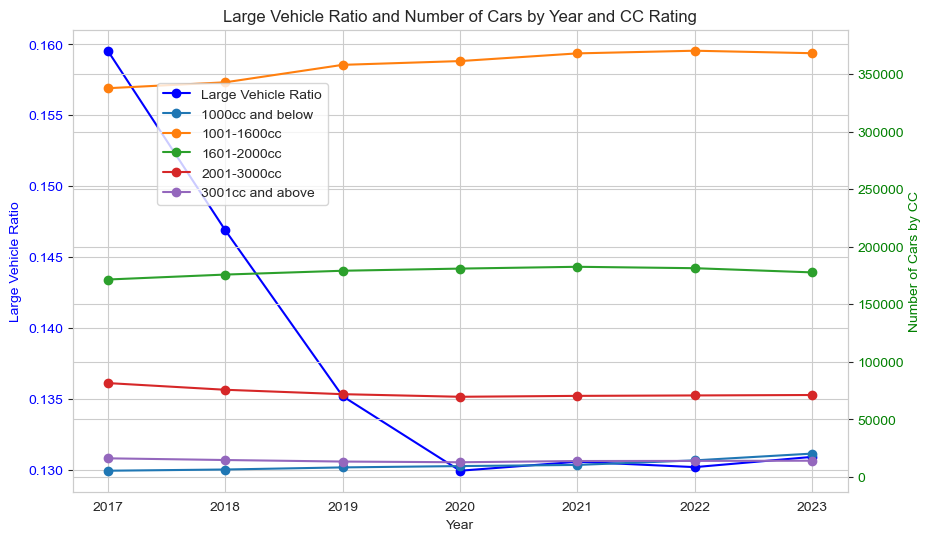

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(yearly_total_vehicles_and_large_vehicle["year"], yearly_total_vehicles_and_large_vehicle["large_vehicle_ratio"], marker='o', linestyle='-', color='b', label='Large Vehicle Ratio')
ax1.set_xlabel('Year')
ax1.set_ylabel('Large Vehicle Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

for cc in vehicle_count_by_year_and_cc.columns:
    ax2.plot(vehicle_count_by_year_and_cc.index, vehicle_count_by_year_and_cc[cc], marker='o', label=cc)

ax2.set_ylabel('Number of Cars by CC', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.title('Large Vehicle Ratio and Number of Cars by Year and CC Rating')
ax1.grid(True)

plt.show()

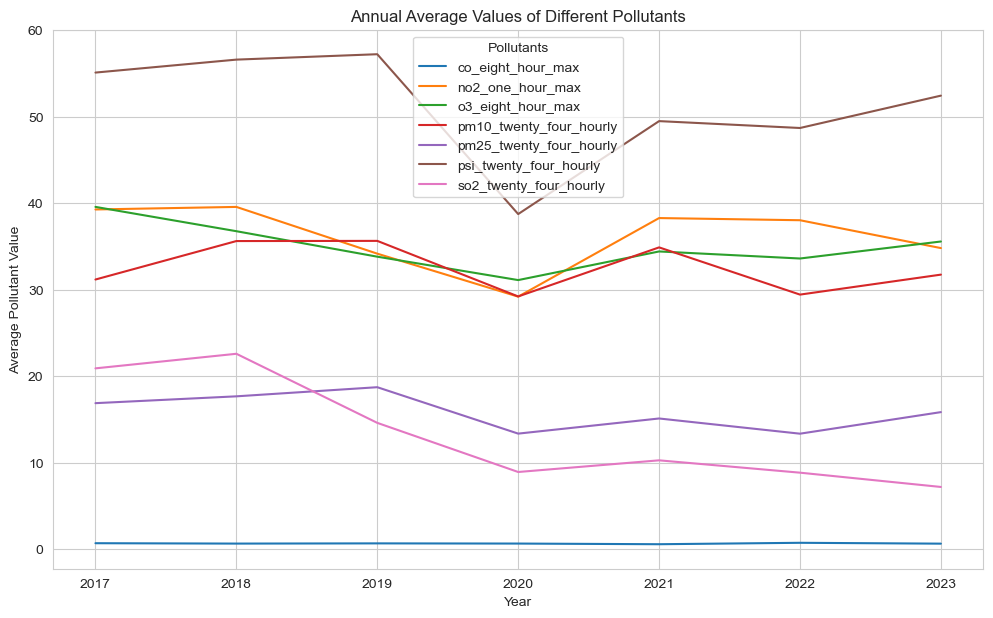

In [54]:
# Extract the pollutant to be analyzed
pollutants = df_yearly_national_pollutant['pollutant'].unique()

plt.figure(figsize=(12, 7))

for pollutant in pollutants:
    # Filter out the current pollutant data
    df_pollutant = df_yearly_national_pollutant[df_yearly_national_pollutant['pollutant'] == pollutant]    
    plt.plot(df_pollutant['year'], df_pollutant['value'], label=pollutant)

plt.title('Annual Average Values of Different Pollutants')
plt.xlabel('Year')
plt.ylabel('Average Pollutant Value')
plt.legend(title='Pollutants')
plt.grid(True)
plt.show()

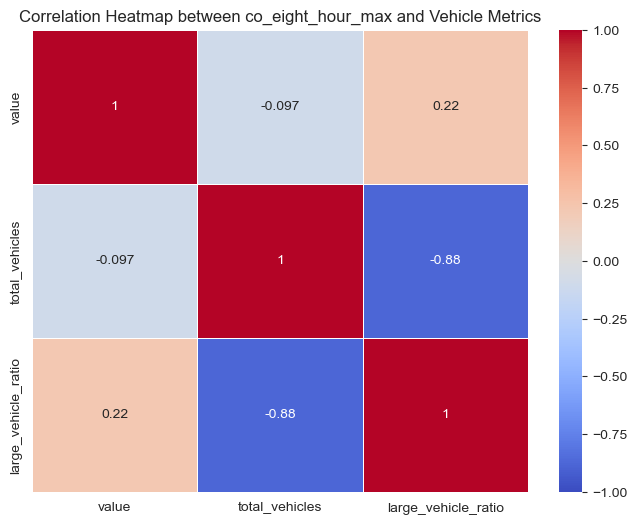

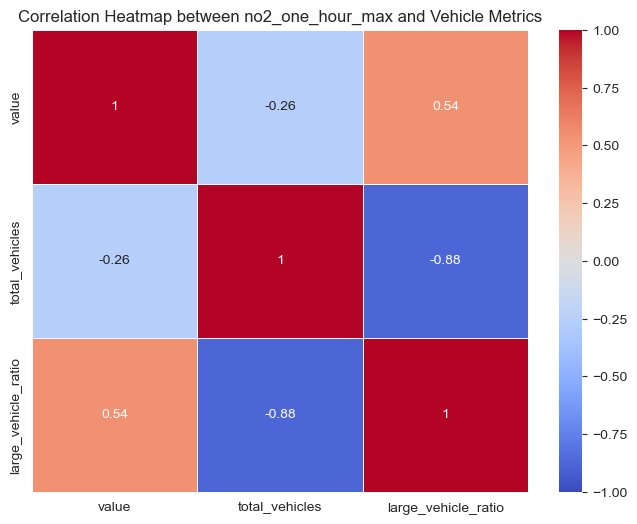

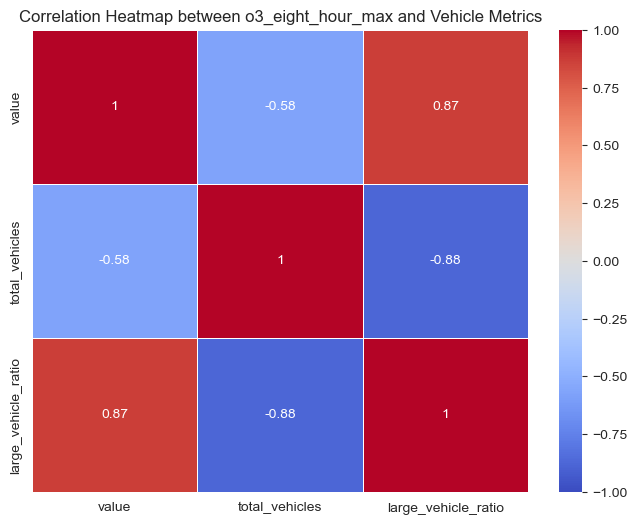

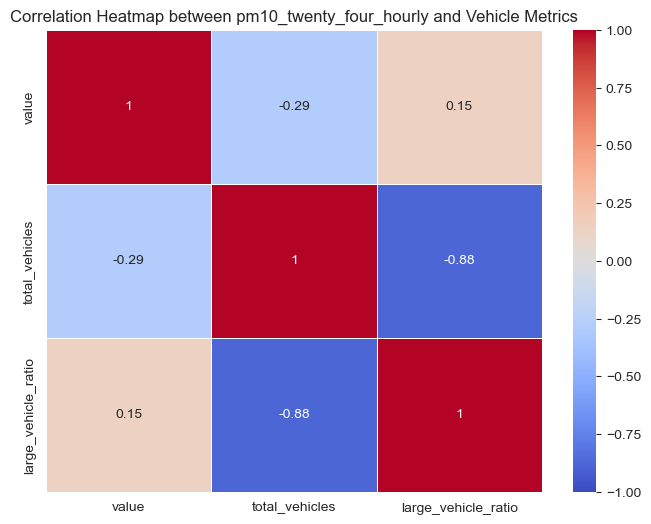

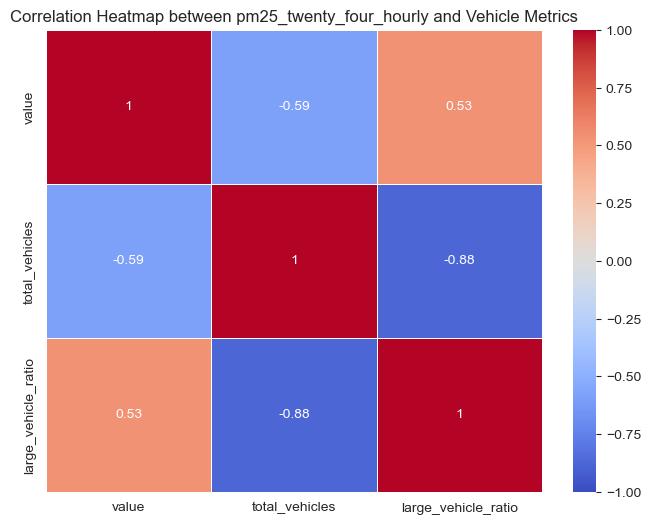

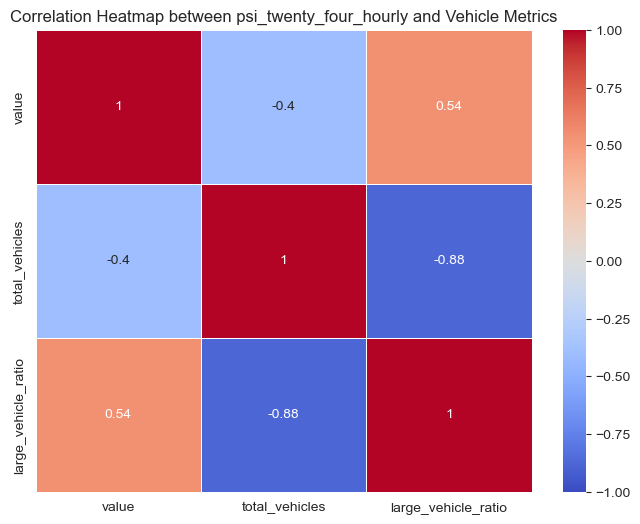

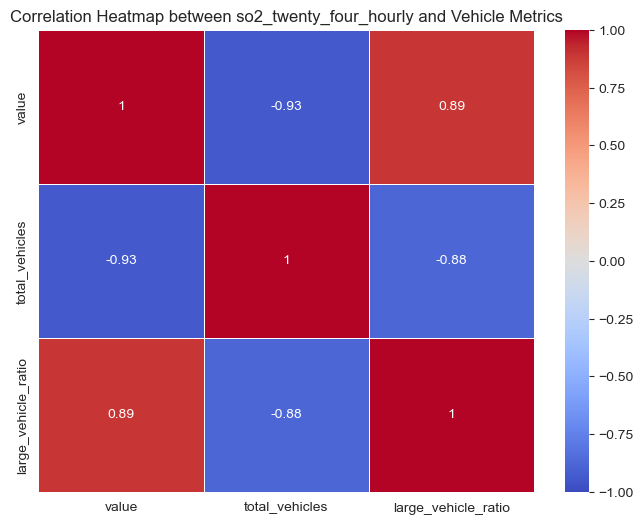

In [55]:
for pollutant in pollutants:
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]

    correlation_matrix = pollutant_data[['value', 'total_vehicles', 'large_vehicle_ratio']].corr()
    
    # Draw heat map to analysis the correlation among pollutant value, total vehicles and large vehicle ratio.
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
    plt.title(f"Correlation Heatmap between {pollutant} and Vehicle Metrics")
    plt.show()

### Data Modelling and Analysis

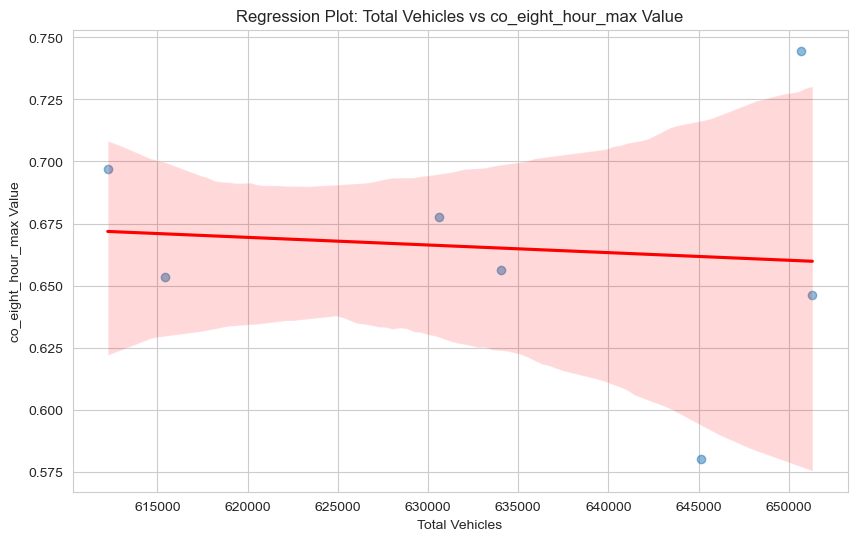

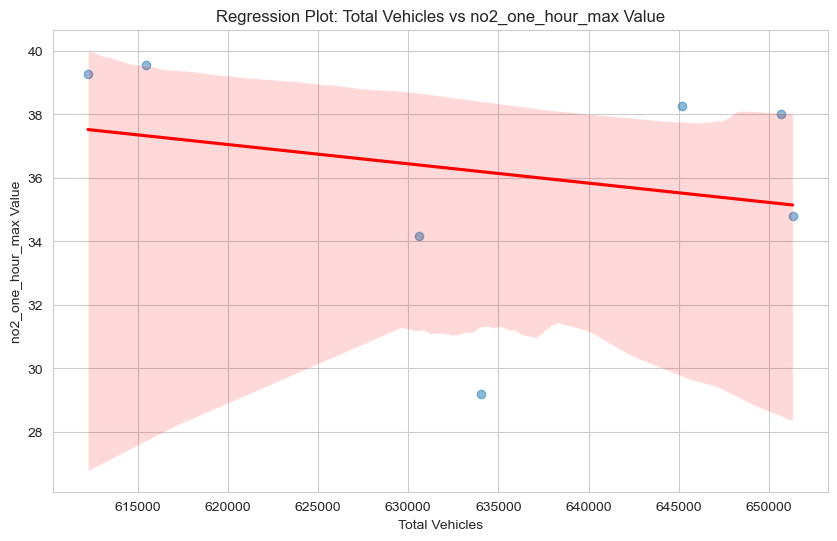

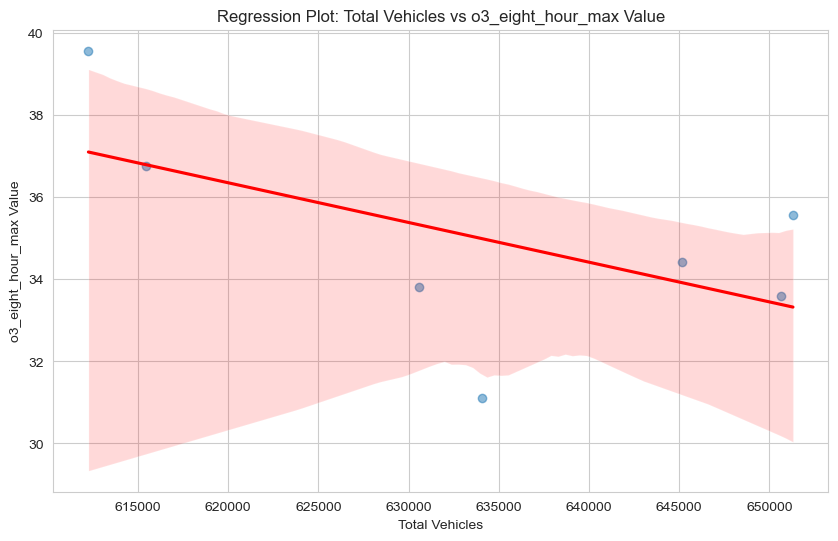

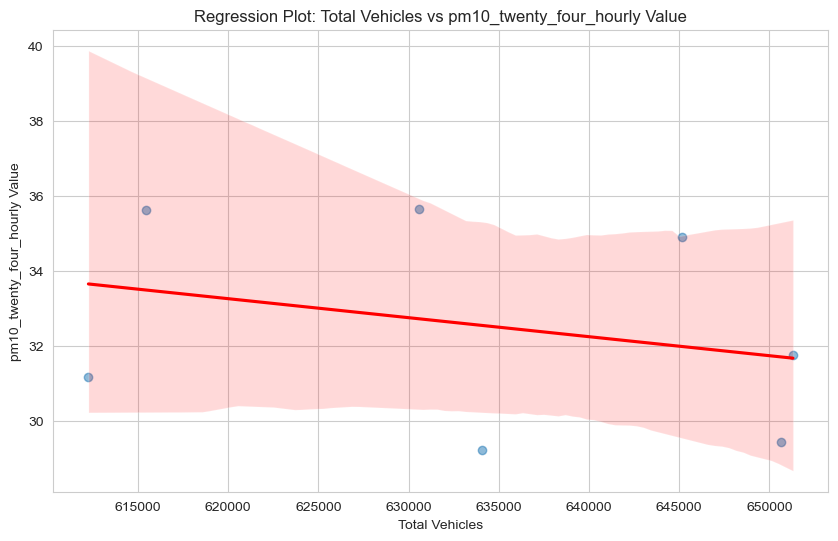

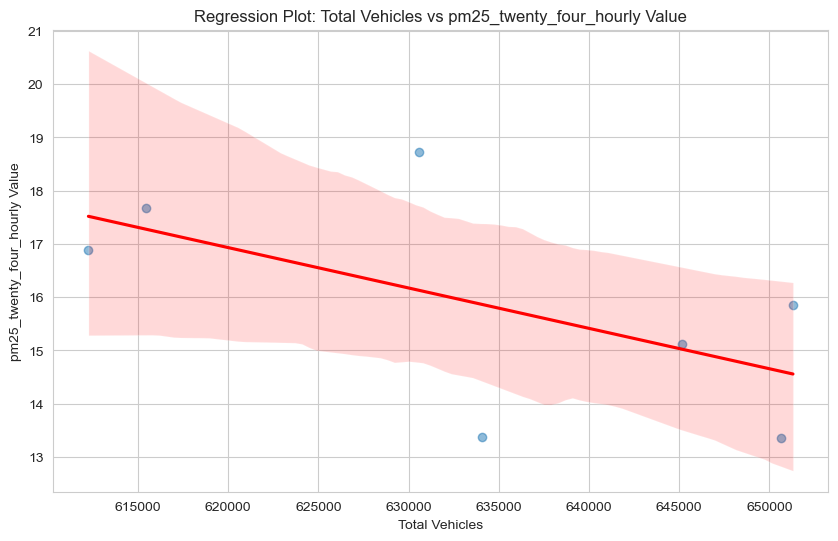

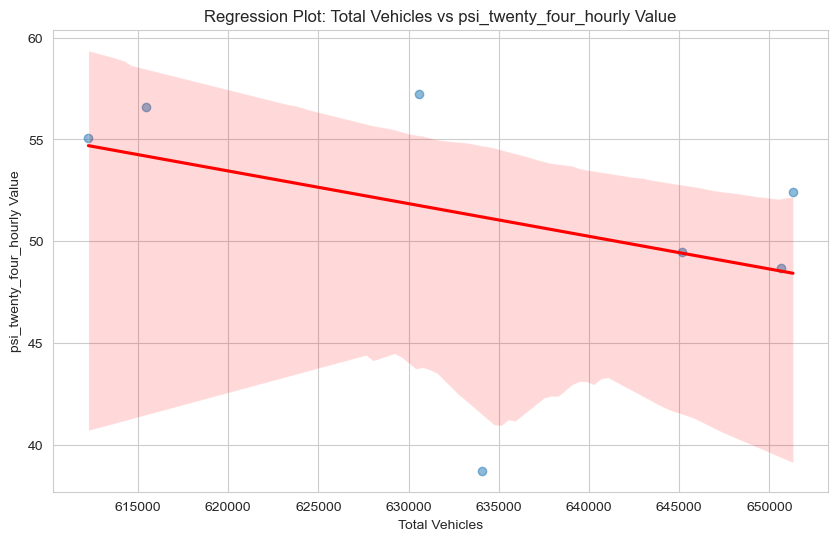

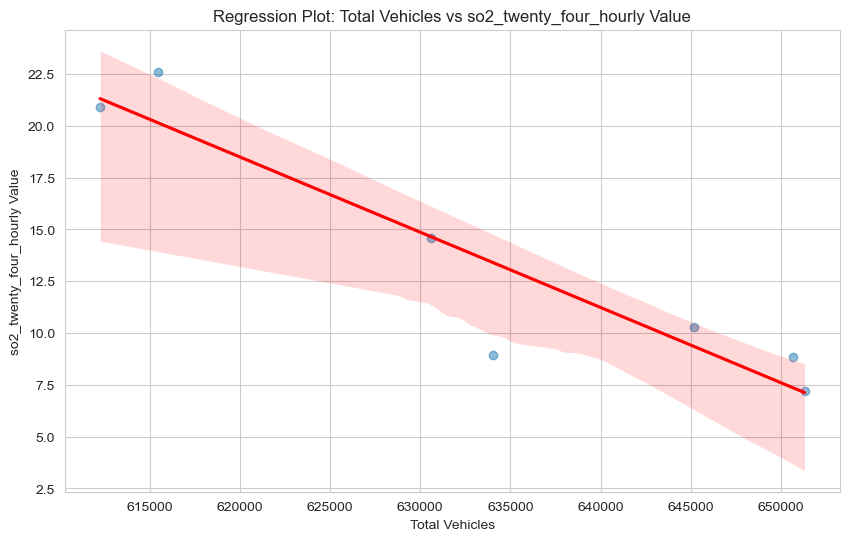

In [10]:
# 分别为每个污染物绘制 total_vehicles 对 value 的回归拟合图
for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    
    # 筛选出当前污染物的数据
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]
    
    # 绘制 total_vehicles 对 value 的回归拟合图
    sns.regplot(x='total_vehicles', y='value', data=pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Total Vehicles vs {pollutant} Value')
    plt.xlabel('Total Vehicles')
    plt.ylabel(f'{pollutant} Value')
    plt.show()
# 分别计算每个污染物的相关系数

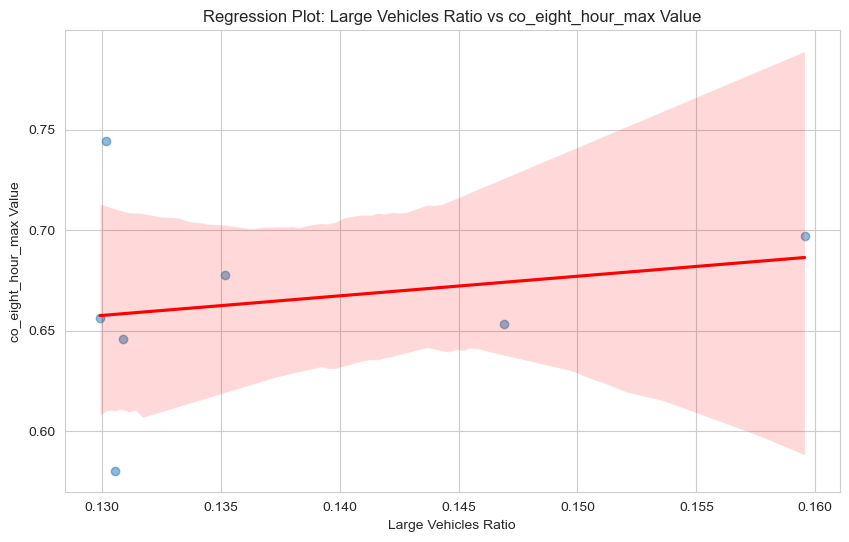

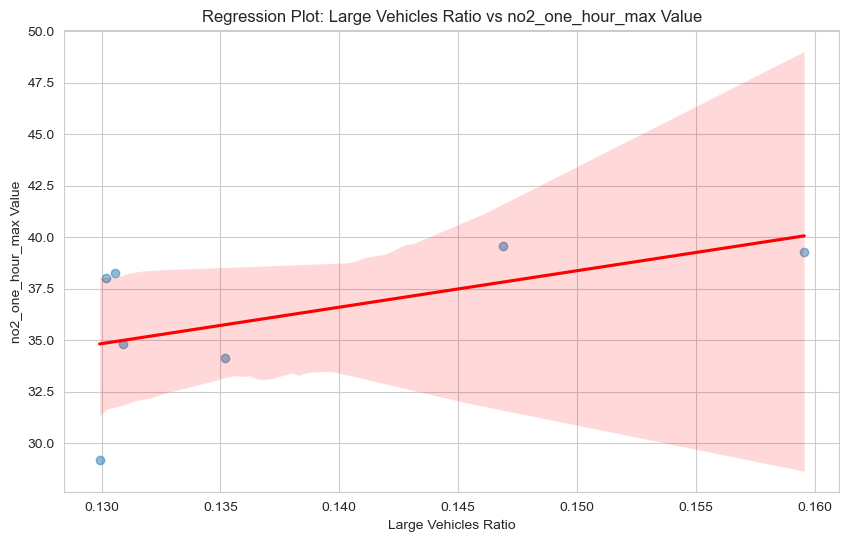

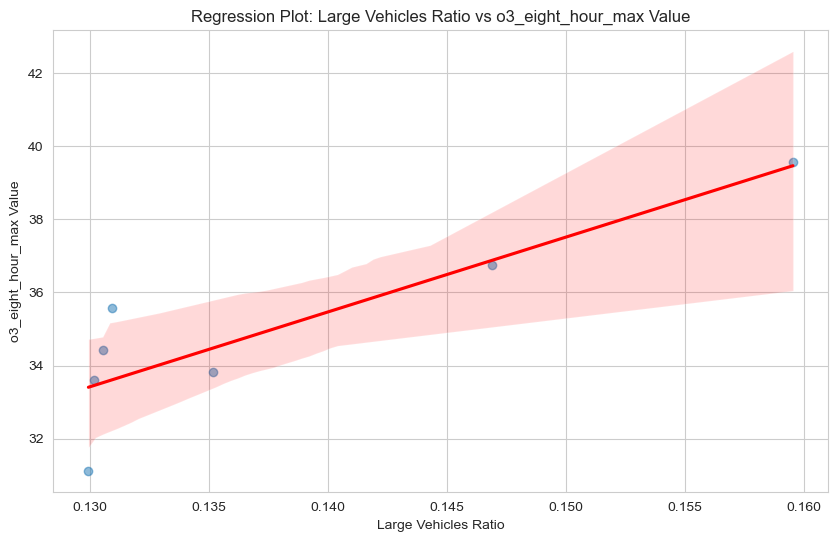

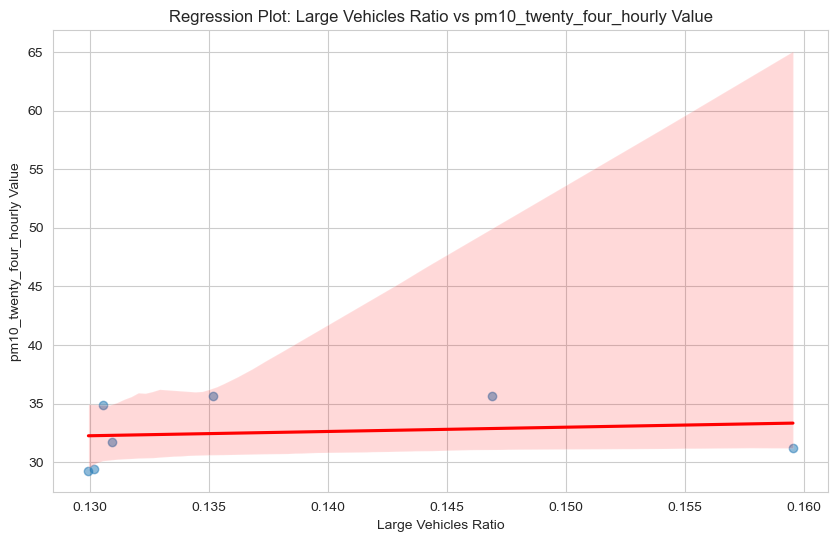

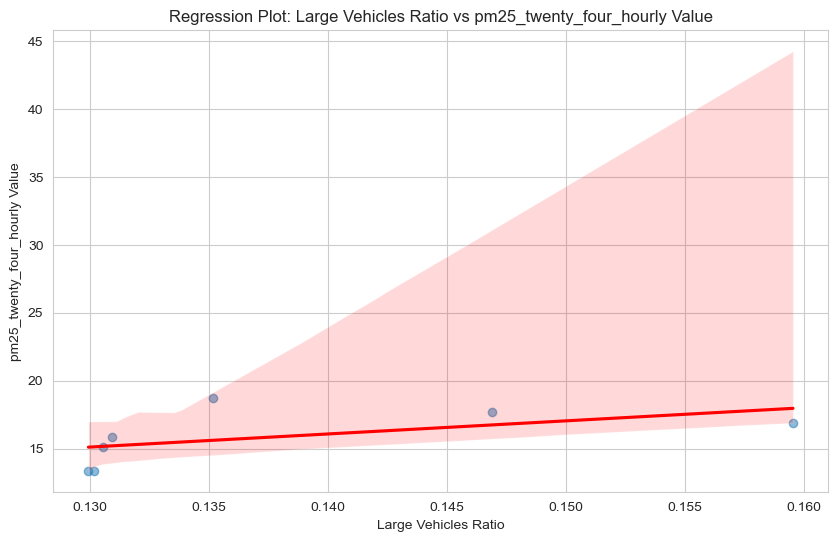

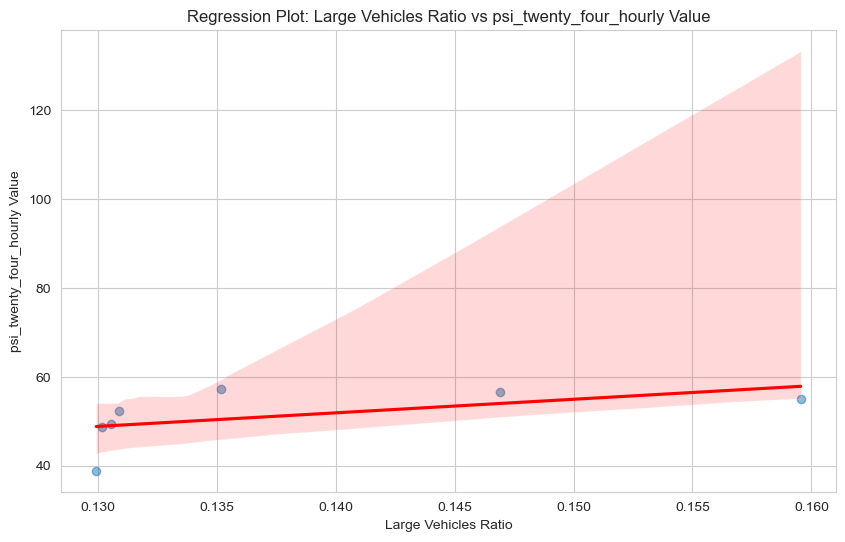

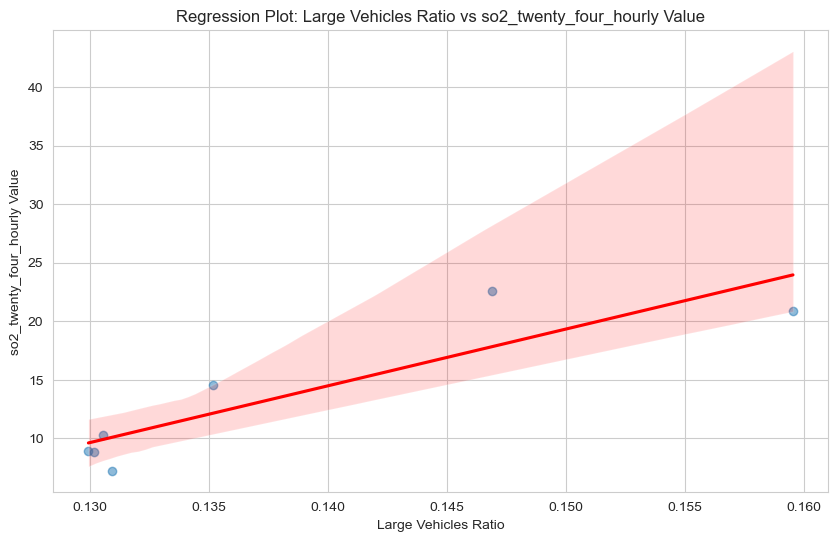

In [17]:
# 分别为每个污染物绘制 total_vehicles 对 value 的回归拟合图
for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    
    # 筛选出当前污染物的数据
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]
    
    # 绘制 total_vehicles 对 value 的回归拟合图
    sns.regplot(x='large_vehicle_ratio', y='value', data=pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Large Vehicles Ratio vs {pollutant} Value')
    plt.xlabel('Large Vehicles Ratio')
    plt.ylabel(f'{pollutant} Value')
    plt.show()

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


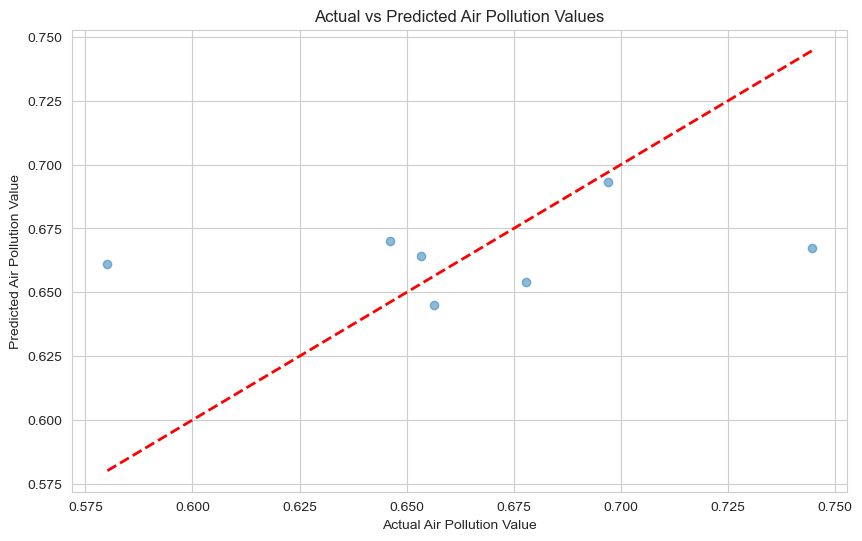

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


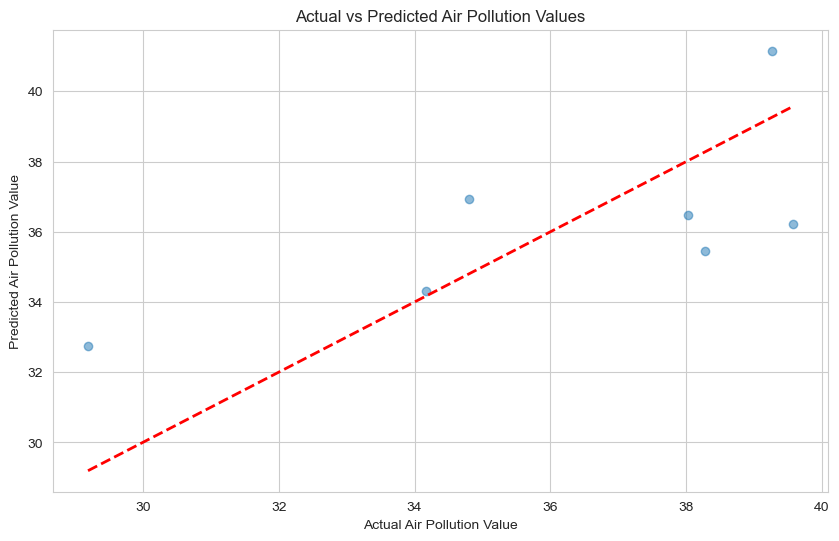

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


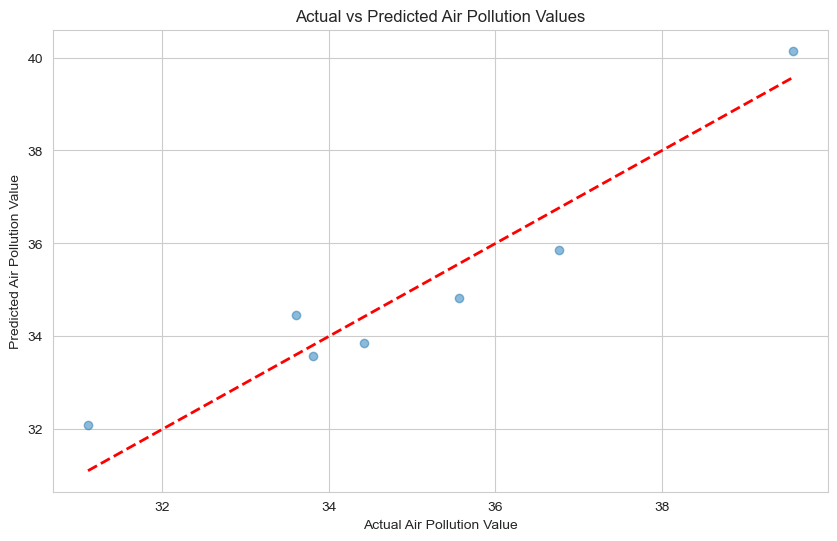

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


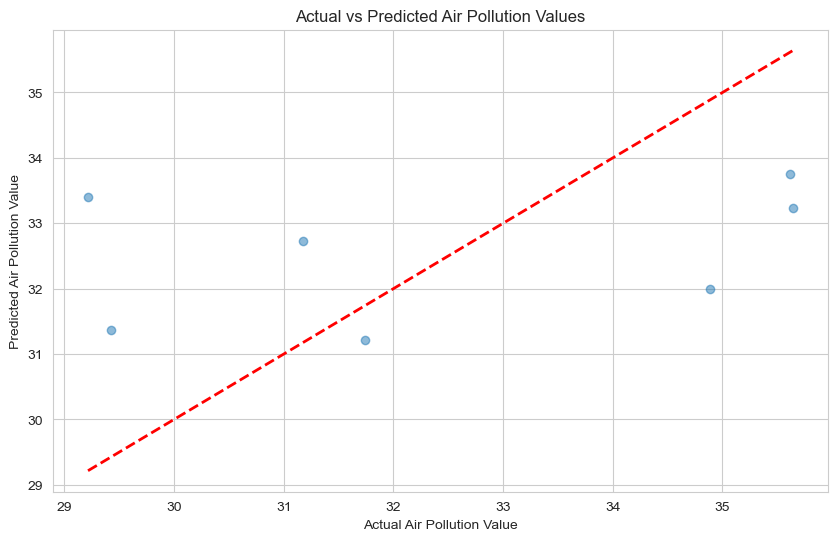

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


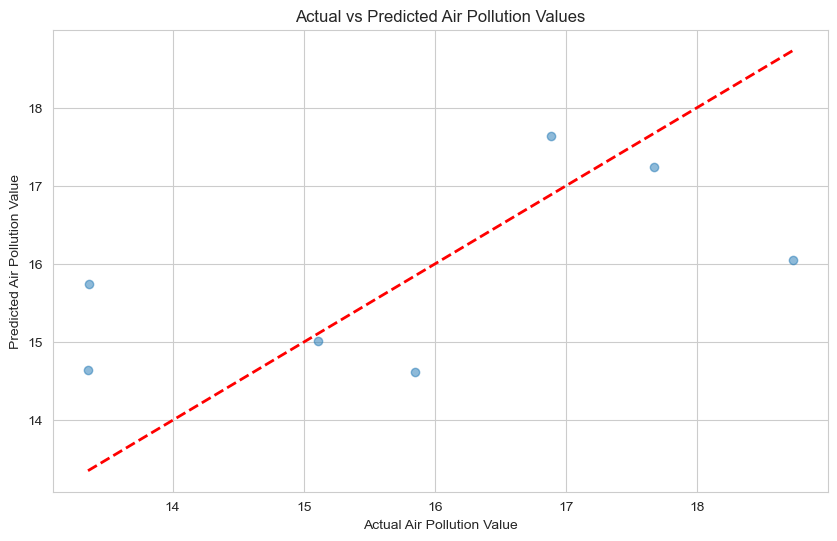

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


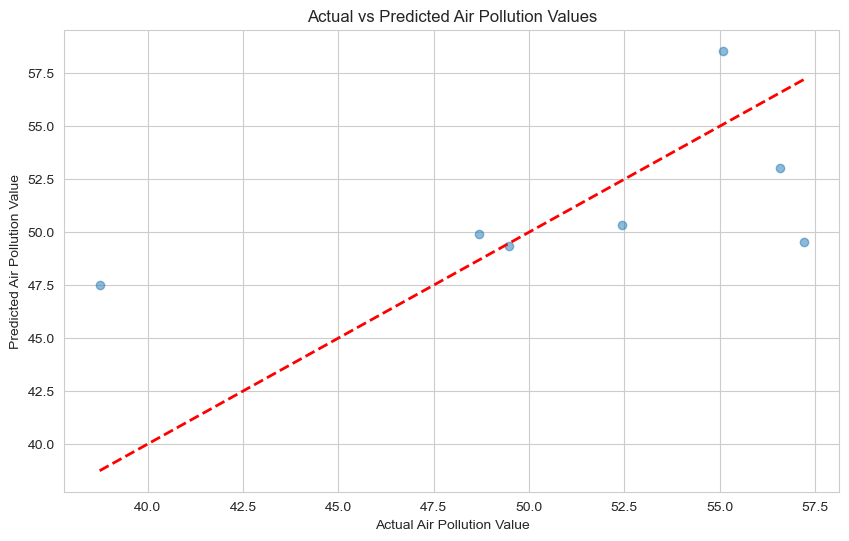

/var/folders/02/l3bygprn2h9b8ybp168cbm5r0000gn/T/ipykernel_9419/176663201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


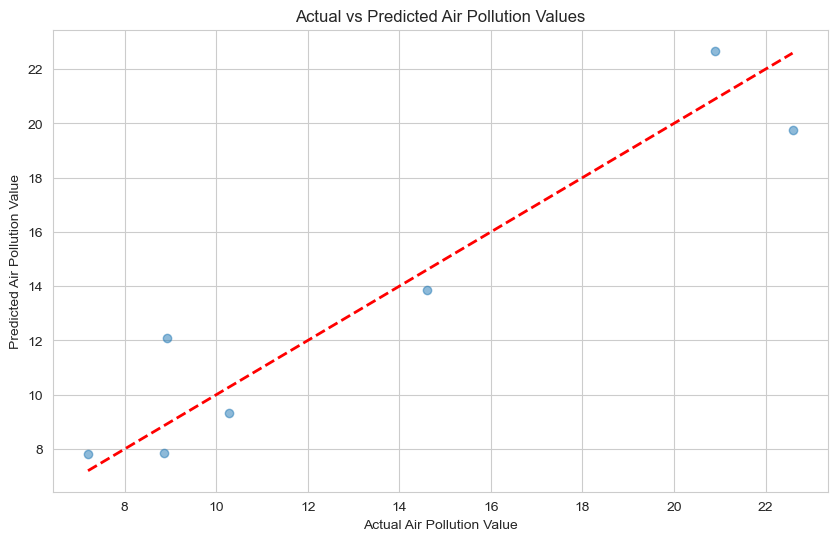

In [15]:
import statsmodels.api as sm
for pollutant in pollutants:
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]
    # 准备数据
    X = pollutant_data[['total_vehicles', 'large_vehicle_ratio']]
    X = sm.add_constant(X)  # 加入常数项
    y = pollutant_data['value']
    
    # 建立线性回归模型
    model = sm.OLS(y, X).fit()
    
    # 生成预测值
    pollutant_data['predicted_value'] = model.predict(X)
    
    # 绘制实际值与预测值对比
    plt.figure(figsize=(10, 6))
    plt.scatter(pollutant_data['value'], pollutant_data['predicted_value'], alpha=0.5)
    plt.plot([pollutant_data['value'].min(), pollutant_data['value'].max()], [pollutant_data['value'].min(), pollutant_data['value'].max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Air Pollution Values')
    plt.xlabel('Actual Air Pollution Value')
    plt.ylabel('Predicted Air Pollution Value')
    plt.show()